# Publications, datasets and software ba a particular researcher

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all DataCite references of the DataCite publications, datasets and software authored by a particular researcher, using his/her ORCID ID.

In [42]:
# Prepare the R graphql client.

#install.packages("httr")
#install.packages("ghql")
#install.packages("jsonlite")
#install.packages("IRdisplay")
#install.packages("dplyr")
#install.packages("igraph")
#install.packages("RColorBrewer")

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")
library("RColorBrewer")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

In [43]:
# Generate the GraphQL query: find the researcher by ORCID ID, then fetch the first 50 publications, datasets and software with DataCite DOIs linked to that ORCID account.

query <- '{
  person(id: "https://orcid.org/0000-0003-1419-2405") {
    id
    type
    name
    publications(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
    datasets(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
    softwareSourceCodes(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
  }
}'

In [44]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [45]:
# Get the name of the researcher with ORCID ID https://orcid.org/0000-0003-1419-2405

display_markdown(data$data$person$name)

Martin Fenner

In [46]:
# Get the number of publications

display_json(data$data$person$publications$totalCount)
display_json(data$data$person$datasets$totalCount)
display_json(data$data$person$softwareSourceCodes$totalCount)

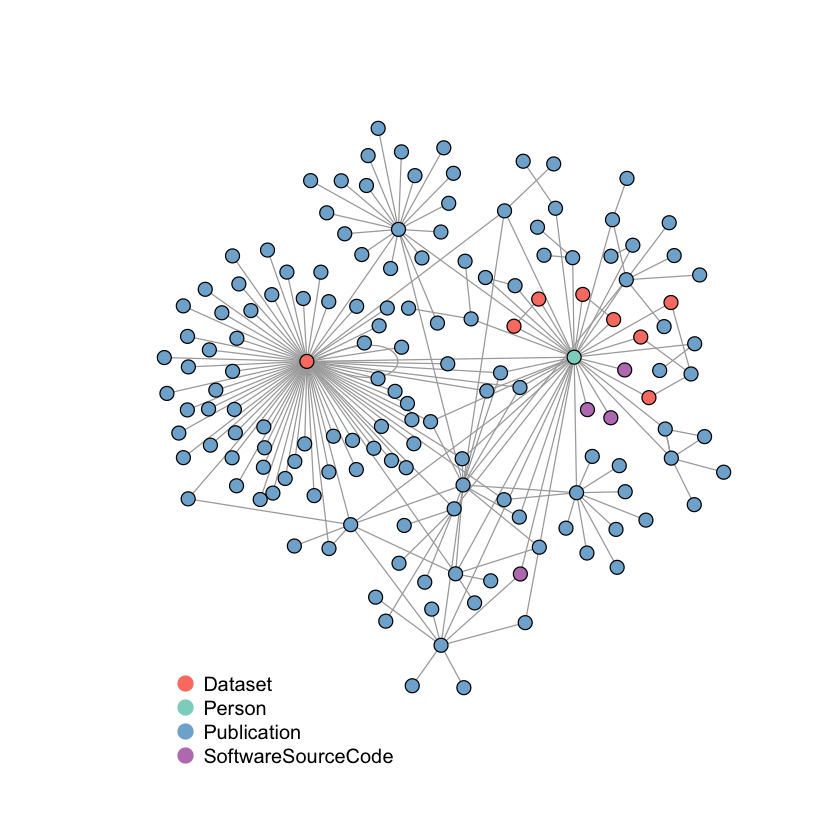

In [47]:
# generate data frame for nodes
people <- data.frame(id=data$data$person$id, pid_type=data$data$person$type)
publications <- data.frame(id=data$data$person$publications$nodes$id, pid_type=c('Publication'))
datasets <- data.frame(id=data$data$person$datasets$nodes$id, pid_type=data$data$person$datasets$nodes$type)
softwareSourceCodes <- data.frame(id=data$data$person$softwareSourceCodes$nodes$id, pid_type=data$data$person$softwareSourceCodes$nodes$type)
publication_references <- data.frame(id=bind_rows(data$data$person$publications$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
dataset_references <- data.frame(id=bind_rows(data$data$person$datasets$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
#software_references <- data.frame(id=bind_rows(data$data$person$softwareSourceCodes$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
nodes <- unique(rbind(people, publications, datasets, softwareSourceCodes, publication_references, dataset_references))

publication_edges <- data.frame(to=publications[,1], from=data$data$person$id)
dataset_edges <- data.frame(to=datasets[,1], from=data$data$person$id)
software_edges <- data.frame(to=softwareSourceCodes[,1], from=data$data$person$id)
edges <- unique(rbind(publication_edges, dataset_edges, software_edges))
    
# loop through nodes, as they can have more than one edge
publications_with_references <- bind_rows(data$data$person$publications$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
datasets_with_references <- bind_rows(data$data$person$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
softwareSourceCodes_with_references <- bind_rows(data$data$person$softwareSourceCodes$nodes) %>% filter(lengths(relatedIdentifiers) != 0)

for (i in 1:nrow(publications_with_references)) {
  row <- data.frame(to=unlist(publications_with_references[i,3]), from=publications_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

for (i in 1:nrow(datasets_with_references)) {
  row <- data.frame(to=unlist(datasets_with_references[i,3]), from=datasets_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

#for (i in 1:nrow(softwareSourceCodes_with_references)) {
#  row <- data.frame(to=unlist(softwareSourceCodes_with_references[i,3]), from=softwareSourceCodes_with_references[i,1])
#  edges <- unique(rbind(edges, row))
#}

# express DOIs as URLs
nodes <- nodes %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
edges <- edges %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

# remove duplicates
nodes <- nodes %>% distinct(id, .keep_all = TRUE)

g <- graph_from_data_frame(d=unique(edges), vertices=unique(nodes))

# add node colors
cols <- brewer.pal(12, "Set3")
V(g)[(V(g)$pid_type=="Publication")]$color<-cols[5]
V(g)[(V(g)$pid_type=="Person")]$color<-cols[1]
V(g)[(V(g)$pid_type=="Dataset")]$color<-cols[4]
V(g)[(V(g)$pid_type=="SoftwareSourceCode")]$color<-cols[10]

# add labels to selected nodes
V(g)$label=NA

V(g)$size <- 5
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)
plot(g, layout=l, arrow.mode=0)

# Add a legend
# pid_type is sorted alphabetically: 'Dataset' 'Person' 'Publication' 'SoftwareSourceCode'
legend("bottomleft", legend=levels(as.factor(V(g)$pid_type)), col = cols[c(4,1,5,10)], bty = "n", pch=20 , pt.cex = 2.5, cex = 1, horiz = FALSE, inset = c(0.1, -0.1))

In [52]:
# Generate a list of formatted citations in APA format for the publications, datasets and software

ids <- substring(publications[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publications')
display_markdown(content(response, as = 'text'))

ids <- substring(datasets[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Datasets')
display_markdown(content(response, as = 'text'))

ids <- substring(softwareSourceCodes[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Software')
display_markdown(content(response, as = 'text'))

## Publications

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691

Friesike, S., &amp; Fenner, M. (2014). Schreiben. https://doi.org/10.2314/COSCV1.4

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691.V1

Fenner, M. (2015, August 17). From Pilot to Service. https://doi.org/10.5438/S8GF-0CK9

Fenner, M. (2016, November 3). A common API for retrieving DataCite Metadata. https://doi.org/10.5438/6WCF-EFW5

Fenner, M., &amp; Garza, K. (2016). Announcing Our New Application Developer. https://doi.org/10.5438/Y131-YX9D

Fenner, M. (2015, September 16). Adding References to the DataCite Blog. https://doi.org/10.5438/2WFX-2HZ1

Fenner, M. (2016, December 15). Cool DOI's. https://doi.org/10.5438/55E5-T5C0

Fenner, M. (2015). Discussing the Scholarly Container. https://doi.org/10.5438/D9EQ-9DGA

Fenner, M. (2016, May 4). Thinking about CSV. https://doi.org/10.5438/4QX3-RP8Y

Fenner, M. (2016, May 13). Data catalog cards: simplifying article/data linking. https://doi.org/10.5438/CAB5-TEG0

Fenner, M. (2016, December 23). Mysteries in Reference Lists. https://doi.org/10.5438/CT8B-X1CE

Fenner, M. (2017, January 9). Using Schema.org for DOI Registration. https://doi.org/10.5438/0000-00CC

Fenner, M. (2017, April 28). A Content Negotiation Update. https://doi.org/10.5438/0000-01QJ

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120248

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120261

Fenner, M. (2018). Open Metrics As Part Of Persistent Identifier Infrastructure. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1250025

Garza, K., &amp; Fenner, M. (2018, June 1). Glad You Asked: A Snapshot of the Current State of Data Citation. https://doi.org/10.5438/H16Y-3D72

Fenner, M. (2016). Eating your own Dog Food. https://doi.org/10.14454/XJ8V-BJ37

Wimalaratne, S., &amp; Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324300

Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324295

Fenner, M. (2018, September 18). COUNTER Code of Practice for Research Data Usage Metrics release 1. https://doi.org/10.5438/NB24-T773

Lowenberg, D., Fenner, M., &amp; Chodacki, J. (2019). 5 Steps Towards a Dream State: Persistent &amp; Open Data Metrics. https://doi.org/10.5281/ZENODO.2547485

Wimalaratne, S., &amp; Fenner, M. (2019, June 24). Please welcome Sarala, our new Head of Infrastructure Services. https://doi.org/10.5438/AJ7F-H903

Fenner, M. (2019). RDA Open Science Graphs for FAIR Data Interest Group. https://doi.org/10.5281/ZENODO.3361405

## Datasets

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90828

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90829

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90828.V1

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90829.V1

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>TEST Kickoff report</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V1

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>D2.2 Kickoff report</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V2

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>TEST do not use!!</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V3

Fenner, M. (2015). <i>DataCite Mandatory Properties</i> [Data set]. DataCite. https://doi.org/10.5438/EA4H-TX3G

## Software

Fenner, M. (2017, April 28). Content-Negotation: an API for DOI content negotiation. DataCite. https://doi.org/10.5438/T1JG-HVHN

Fenner, M. (2019, June 30). FREYA PID Graph Key Performance Indicators (KPIs) (Version 1.0.0). DataCite. https://doi.org/10.14454/3BPW-W381

Fenner, M. (2019). Omniauth-globus: provides basic support for authenticating a client application via the Globus service. <i>DataCite</i>. https://doi.org/10.14454/81GP-9Y63

Fenner, M. (2019). FREYA PID Graph for a specific researcher (Version 1.0.0). <i>DataCite</i>. https://doi.org/10.14454/628M-3882

In [62]:
# Generate a list of formatted citations in APA format for the references (if they are DataCite DOIs)

ids <- publication_references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publication References')
display_markdown(content(response, as = 'text'))

ids <- dataset_references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Dataset References')
display_markdown(content(response, as = 'text'))  

## Publication References

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691

Heller, L., Blümel, I., Dietze, S., Fenner, M., Friesike, S., Hauschke, C., … Tullney, M. (2014). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV1

DataCite Metadata Working Group. (2016). DataCite Metadata Schema Documentation for the Publication and Citation of Research Data v4.0. <i>DataCite E.V.</i> https://doi.org/10.5438/0012

Farquhar, A., Aryani, A., Brown, J., Burton, A., Cruise, P., Dallmeier-Thiessen, S., … Vision, T. (2015). Technical and Human Infrastructure for Open Research (THOR). DataCite. https://doi.org/10.5438/6423

Fenner, M. (2016). Eating your own Dog Food. https://doi.org/10.5438/4K3M-NYVG

Hull, E. (2016, March 28). The Location of the Citation: are Data Citation Recommendations Having an Effect? https://doi.org/10.5438/F17B-45VZ

Fenner, M. (2016, December 15). Cool DOI's. https://doi.org/10.5438/55E5-T5C0

Fenner, M. (2016, November 1). Announcing the Organization Identifier Project: a Way Forward. https://doi.org/10.5438/TNHX-54CG

Cruse, P., Rueda, L., Garza, K., &amp; Fenner, M. (2015, August 3). DataCite Blog (Version 1.0). DataCite. https://doi.org/10.5438/0000-00SS

Fenner, M. (2017, January 9). Using Schema.org for DOI Registration. https://doi.org/10.5438/0000-00CC

Fenner, M. (2017, February 25). Bolognese: a Ruby library for conversion of DOI Metadata. DataCite. https://doi.org/10.5438/N138-Z3MK

Fenner, M. (2017, April 28). Content-Negotation: an API for DOI content negotiation. DataCite. https://doi.org/10.5438/T1JG-HVHN

Data Citation Synthesis Group. (2014). <i>Joint Declaration of Data Citation Principles</i>. Force11. https://doi.org/10.25490/A97F-EGYK

DataCite Metadata Working Group. (2017). DataCite Metadata Schema Documentation for the Publication and Citation of Research Data v4.1. <i>DataCite</i>. https://doi.org/10.5438/0014

Fenner, M. (2017). Article-Data Linking Workshop November 2016. https://doi.org/10.5281/ZENODO.1063636

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120249

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120248

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120261

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120265

La Bruzzo, S., &amp; Manghi, P. (2017, November 21). The Scholix Metadata Schema (Json And Xml). Zenodo. https://doi.org/10.5281/ZENODO.1120275

Fenner, M. (2018). Open Metrics As Part Of Persistent Identifier Infrastructure. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1250026

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1263942

Wimalaratne, S., &amp; Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324300

Wimalaratne, S., &amp; Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324299

Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324296

Noy, N., Cousijn, H., Hirsch, M., &amp; Fenner, M. (2018, December 12). Google Dataset Search Webinar - everything you always wanted to know about Google Dataset Search. https://doi.org/10.5438/4SDJ-HF49

Lowenberg, D., Fenner, M., &amp; Chodacki, J. (2019). 5 Steps Towards a Dream State: Persistent &amp; Open Data Metrics. https://doi.org/10.5281/ZENODO.2547484

Baumgardner, G. D., &amp; Shaffer, B. S. (2015). Sliding Bones: Movement of Skeletal Material Over Smith Creek Playa in Nevada and Its Taphonomic and Paleontologic Implications. <i>Western North American Naturalist</i>, <i>75</i>(2), 236–243. https://doi.org/10.3398/064.075.0213

El-Maarry, M. R., Watters, W. A., Yoldi, Z., Pommerol, A., Fischer, D., Eggenberger, U., &amp; Thomas, N. (2015). Field investigation of dried lakes in western United States as an analogue to desiccation fractures on Mars. <i>Journal of Geophysical Research: Planets</i>, <i>120</i>(12), 2241–2257. https://doi.org/10.1002/2015JE004895

Fenner, M. (2013). What Can Article-Level Metrics Do for You? <i>PLoS Biology</i>, <i>11</i>(10), e1001687. https://doi.org/10.1371/JOURNAL.PBIO.1001687

Grayson, D. K., &amp; Meltzer, D. J. (2015). Revisiting Paleoindian exploitation of extinct North American mammals. <i>Journal of Archaeological Science</i>, <i>56</i>, 177–193. https://doi.org/10.1016/J.JAS.2015.02.009

Jones, R., &amp; Hooke, R. L. B. (2015). Racetrack Playa: Rocks moved by wind alone. <i>Aeolian Research</i>, <i>19</i>, 1–3. https://doi.org/10.1016/J.AEOLIA.2015.08.001

Li, M., Zhou, S., &amp; Wang, G. (2016). 3D identification and stability analysis of key surface blocks of rock slope. <i>Transactions of Tianjin University</i>, <i>22</i>(4), 317–323. https://doi.org/10.1007/S12209-016-2596-Z

Lorenz, R. D., Norris, J. M., Jackson, B. K., Norris, R. D., Chadbourne, J. W., &amp; Ray, J. (2014). Trail formation by ice-shoved &quot;sailing stones&quot; observed at Racetrack Playa, Death Valley National Park. <i>Earth Surface Dynamics Discussions</i>, <i>2</i>(2), 1005–1022. https://doi.org/10.5194/ESURFD-2-1005-2014

Norris, R. D., Norris, J. M., Lorenz, R. D., Ray, J., &amp; Jackson, B. (2014). Sliding Rocks on Racetrack Playa, Death Valley National Park: First Observation of Rocks in Motion. <i>PLoS ONE</i>, <i>9</i>(8), e105948. https://doi.org/10.1371/JOURNAL.PONE.0105948

Rambo, R. P., &amp; Tainer, J. A. (2015). Modeling Macromolecular Motions by X-Ray-Scattering-Constrained Molecular Dynamics. <i>Biophysical Journal</i>, <i>108</i>(10), 2421–2423. https://doi.org/10.1016/J.BPJ.2015.04.023

Sanz-Montero, M. E., Cabestrero, Ó., &amp; Rodríguez-Aranda, J. P. (2015). Sedimentary effects of flood-producing windstorms in playa lakes and their role in the movement of large rocks. <i>Earth Surface Processes and Landforms</i>, <i>40</i>(7), 864–875. https://doi.org/10.1002/ESP.3677

Sanz-Montero, M. E., Cabestrero, Ó., &amp; Rodríguez-Aranda, J. P. (2016). Comments on Racetrack playa: Rocks moved by wind alone. <i>Aeolian Research</i>, <i>20</i>, 196–197. https://doi.org/10.1016/J.AEOLIA.2016.01.003

Schoenemann, B. (2016). A Miniscule System of a ‘Sailing Rock.’ <i>Journal of Geology &amp; Geophysics</i>, <i>5</i>(5). https://doi.org/10.4172/2381-8719.1000256

Tenopir, C., Dalton, E. D., Allard, S., Frame, M., Pjesivac, I., Birch, B., … Dorsett, K. (2015). Changes in Data Sharing and Data Reuse Practices and Perceptions among Scientists Worldwide. <i>PLOS ONE</i>, <i>10</i>(8), e0134826. https://doi.org/10.1371/JOURNAL.PONE.0134826

Whitlock, M. C. (2011). Data archiving in ecology and evolution: best practices. <i>Trends in Ecology &amp; Evolution</i>, <i>26</i>(2), 61–65. https://doi.org/10.1016/J.TREE.2010.11.006

Starr, J., Castro, E., Crosas, M., Dumontier, M., Downs, R. R., Duerr, R., … Clark, T. (2015). Achieving human and machine accessibility of cited data in scholarly publications. <i>PeerJ Computer Science</i>, <i>1</i>, e1. https://doi.org/10.7717/PEERJ-CS.1

Fenner, M., Wass, J., Demeranville, T., Wimalaratne, S., &amp; Hallett, R. (2019). D2.2 PID Metadata Provenance. https://doi.org/10.5281/ZENODO.3248652

Sansone, S.-A., Gonzalez-Beltran, A., Rocca-Serra, P., Alter, G., Grethe, J. S., Xu, H., … Members, bioC. A. D. D. I. E. W. G. (2017). DATS: the data tag suite to enable discoverability of datasets. <i>BioRxiv</i>. https://doi.org/10.1101/103143

Burke, K. (2014). A Safety Net for Scientific Data. <i>American Scientist</i>, <i>102</i>(1), 6. https://doi.org/10.1511/2014.106.6

Bierer, B. E., Crosas, M., &amp; Pierce, H. H. (2017). Data Authorship as an Incentive to Data Sharing. <i>New England Journal of Medicine</i>, <i>376</i>(17), 1684–1687. https://doi.org/10.1056/NEJMSB1616595

Kafkas, Ş., Kim, J.-H., &amp; McEntyre, J. R. (2013). Database Citation in Full Text Biomedical Articles. <i>PLoS ONE</i>, <i>8</i>(5), e63184. https://doi.org/10.1371/JOURNAL.PONE.0063184

Klein, M., Van de Sompel, H., Sanderson, R., Shankar, H., Balakireva, L., Zhou, K., &amp; Tobin, R. (2014). Scholarly Context Not Found: One in Five Articles Suffers from Reference Rot. <i>PLoS ONE</i>, <i>9</i>(12), e115253. https://doi.org/10.1371/JOURNAL.PONE.0115253

McEntyre, J., Sarkans, U., &amp; Brazma, A. (2015). The BioStudies database. <i>Molecular Systems Biology</i>, <i>11</i>(12), 847–847. https://doi.org/10.15252/MSB.20156658

Garza, K., Goble, C., Brooke, J., &amp; Jay, C. (2015). Framing the community data system interface. <i>Association for Computing Machinery (ACM)</i>. https://doi.org/10.1145/2783446.2783605

Wimalaratne, S. M., Juty, N., Kunze, J., Janée, G., McMurry, J. A., Beard, N., … Clark, T. (2018). Uniform resolution of compact identifiers for biomedical data. <i>Scientific Data</i>, <i>5</i>, 180029. https://doi.org/10.1038/SDATA.2018.29

Kratz, J. E., &amp; Strasser, C. (2015). Making data count. <i>Scientific Data</i>, <i>2</i>(1). https://doi.org/10.1038/SDATA.2015.39

Hrynaszkiewicz, I., Birukou, A., Astell, M., Swaminathan, S., Kenall, A., &amp; Khodiyar, V. (2017). Standardising and harmonising research data policy in scholarly publishing. <i>BioRxiv</i>. https://doi.org/10.1101/122929

Fenner, M. (2019). RDA Open Science Graphs for FAIR Data Interest Group. https://doi.org/10.5281/ZENODO.3361404

## Dataset References

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90828

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90829

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019

Cruse, P. (2016, October 14). DataCite Welcomes TIND. https://doi.org/10.5438/1YAA-K6D1

Katz, D. S. (2016, April 17). To better understand research communication, we need a GROUPID (group object identifier). https://doi.org/10.5438/SHR4-2BS2

Fenner, M. (2015, August 17). From Pilot to Service. https://doi.org/10.5438/S8GF-0CK9

Fenner, M. (2016). Eating your own Dog Food. https://doi.org/10.5438/4K3M-NYVG

Fenner, M. (2016, November 3). A common API for retrieving DataCite Metadata. https://doi.org/10.5438/6WCF-EFW5

Rueda, L. (2016, September 1). PIDapalooza, the festival of persistent identifiers is coming soon! https://doi.org/10.5438/PRF0-NRXQ

Pampel, H. (2016, April 13). re3data.org Reaches a Milestone and Begins Offering Badges. https://doi.org/10.5438/KTR7-ZJJH

Fenner, M. (2015, August 15). Reference Lists and Tables of Content. https://doi.org/10.5438/5AEG-WEEV

Rueda, L. (2016, September 20). Software Citation Principles. https://doi.org/10.5438/WMAS-KM0V

Fenner, M. (2015). <i>DataCite Mandatory Properties</i> [Data set]. DataCite. https://doi.org/10.5438/EA4H-TX3G

Rueda, L. (2016, December 19). 2016 in review. https://doi.org/10.5438/ZWSF-4Y7Y

Fenner, M. (2015). Software Citation Workflows. https://doi.org/10.5438/1H7N-3CEN

Fenner, M. (2015, October 26). Auto-Update Has Arrived! https://doi.org/10.5438/FERW-CWHQ

Hull, E. (2016, March 28). The Location of the Citation: are Data Citation Recommendations Having an Effect? https://doi.org/10.5438/F17B-45VZ

Fenner, M., &amp; Garza, K. (2016). Announcing Our New Application Developer. https://doi.org/10.5438/Y131-YX9D

Fenner, M. (2015, September 16). Adding References to the DataCite Blog. https://doi.org/10.5438/2WFX-2HZ1

Fenner, M. (2016, December 15). Cool DOI's. https://doi.org/10.5438/55E5-T5C0

Cruse, P. (2016, May 18). Get involved in the DataCite Community! https://doi.org/10.5438/MRR6-MF3Q

Fenner, M. (2015, September 22). Persistent Identifiers: Enabling Services for Data Intensive Research. https://doi.org/10.5438/JM9F-325F

Cruse, P. (2016). DataCite’s New Membership Model - Join Us! https://doi.org/10.5438/8SZS-1H0H

Lin, J. (2015). When Counting is Hard. <i>DataCite Blog</i>. https://doi.org/10.5438/02BH-TGC7

Fenner, M. (2015, December 23). Infrastructure Tips for the Non-Profit Startup. https://doi.org/10.5438/T0AP-D5W7

Fenner, M. (2015). Discussing the Scholarly Container. https://doi.org/10.5438/D9EQ-9DGA

Rueda, L. (2016, May 17). Zotero for Data Repositories Webinar. https://doi.org/10.5438/Q2GH-6EGD

Fenner, M. (2015, December 28). Announcing the DataCite Blog Relaunch. https://doi.org/10.5438/XCBJ-G7ZY

Cruse, P. (2015, November 2). DataCite Is an Exciting Place to Be. https://doi.org/10.5438/GA8V-FA94

Rueda, L. (2016, October 24). The Tsinghua University Library joins DataCite. https://doi.org/10.5438/ESYS-F867

Fenner, M. (2015). Overcoming Development Pain (Version 1.0). https://doi.org/10.5438/8QKH-1R6~

Jensen, L. J. (2016, May 1). Tip: Getting data into Impactstory but not your ORCID profile. https://doi.org/10.5438/78P9-FNRN

Fenner, M. (2015, November 9). Announcing the DataCite Profiles Service. https://doi.org/10.5438/15X1-BJ6R

Pampel, H. (2016, February 24). Enhancements to creating and updating re3data. https://doi.org/10.5438/6GEP-3S5E

Fenner, M. (2016, May 4). Thinking about CSV. https://doi.org/10.5438/4QX3-RP8Y

Witt, M. (2016, January 20). New re3data.org Schema and Search Functionality. https://doi.org/10.5438/4BY7-B7ZN

Fenner, M. (2015). Data-Driven Development. https://doi.org/10.5438/5PS5-G3V~

Cruse, P. (2015, October 4). Recap: Persistent Identifiers in Paris. https://doi.org/10.5438/85SN-MX23

Rueda, L. (2016, July 8). DataCite Metadata Schema 4.0 Webinar. https://doi.org/10.5438/X4JQ-EGT5

Rueda, L. (2015, December 5). DataCite Profiles and ORCID Auto-Update webinar. https://doi.org/10.5438/CJT2-T6DZ

Fenner, M. (2015, September 3). Using YAML Frontmatter with CSV. https://doi.org/10.5438/5HZJ-5KDS

Fenner, M. (2016, April 14). It's all about Relations. https://doi.org/10.5438/PE54-ZJ5T

Fenner, M. (2015, October 1). Thoughts on the Research Data Alliance 6th Plenary. https://doi.org/10.5438/7RXD-S8A3

Cruse, P. (2016, October 17). Welcome United States Geological Survey (USGS). https://doi.org/10.5438/9JWD-TN3A

Fenner, M. (2016, May 13). Data catalog cards: simplifying article/data linking. https://doi.org/10.5438/CAB5-TEG0

Cruse, P. (2016, March 31). General Assembly 2016, moving DataCite forward. https://doi.org/10.5438/C81T-HKVP

Fenner, M. (2015, September 9). Announcing Data-Level Metrics in DataCite Labs. https://doi.org/10.5438/JZG5-VCQV

Fenner, M. (2016, November 1). Announcing the Organization Identifier Project: a Way Forward. https://doi.org/10.5438/TNHX-54CG

Fenner, M. (2016, July 18). Dynamic Data Citation Webinar. https://doi.org/10.5438/Y4KS-KSBC

Fenner, M. (2015, October 16). Happy Birthday ORCID. https://doi.org/10.5438/C61Q-Z2K7

Castro, E. (2016, March 30). Dataverse is now minting DOIs with DataCite Metadata Store API. https://doi.org/10.5438/BMMQ-YCE9

Rueda, L. (2016, September 21). New DataCite Metadata Schema 4.0. https://doi.org/10.5438/VQ3X-QDWT

Fenner, M. (2015, August 20). Digging into Metadata using R. https://doi.org/10.5438/1HV8-2GC2

Fenner, M. (2015, October 29). Explaining the DataCite/ORCID Auto-update. https://doi.org/10.5438/3DFW-Z4KQ

Fenner, M. (2016, January 11). Launching the DataCite Status Page. https://doi.org/10.5438/YHCJ-P5HR

Fenner, M. (2015, September 18). Differences between ORCID and DataCite Metadata. https://doi.org/10.5438/BC11-CQW1

Fenner, M. (2016, March 30). DataCite is Hiring an Application Developer. https://doi.org/10.5438/MSK0-15R2

Fenner, M. (2016, July 5). Relaunching DataCite Search. https://doi.org/10.5438/VQ2T-VR4K

Rueda, L. (2016, June 27). Our New Website: Dynamic, Responsive and Adapted to your Needs. https://doi.org/10.5438/QW2X-PGCY

Fenner, M. (2015). Contributor Information in DataCite Metadata. <i>DataCite Blog</i>. https://doi.org/10.5438/W029-Y6W~

Rueda, L. (2016, March 11). Open Science, Open Data and DataCite DOIs. https://doi.org/10.5438/SS2R-9CNS

Fenner, M. (2016, April 19). We were out in Force. https://doi.org/10.5438/C3BY-VYZS

Witt, M. (2015, November 25). re3data Webinar and DataCite: En Avant! https://doi.org/10.5438/MCNV-GA6N

Fenner, M. (2016, December 23). Mysteries in Reference Lists. https://doi.org/10.5438/CT8B-X1CE

Rueda, L. (2016, February 18). DataCite to Dublin Core application profile (DC2AP). https://doi.org/10.5438/0000-040H

Fenner, M. (2017, January 9). Using Schema.org for DOI Registration. https://doi.org/10.5438/0000-00CC

Rueda, L. (2017, March 2). Welcoming Children’s Hospital of Philadelphia to the community! https://doi.org/10.5438/0000-9G41

Cruse, P. (2017, March 30). The OI Project gets underway planning an Open Organization Identifier Registry. https://doi.org/10.5438/0000-0C2G

Witt, M. (2017, April 19). DataCite’s re3data wins Oberly Award from the American Libraries Association. https://doi.org/10.5438/0001-0HN*

Cruse, P. (2017, April 23). Welcome DataCite’s New Executive Board Members. https://doi.org/10.5438/0000-16JD

Rueda, L. (2017, May 18). Make Data Count: Building a System to Support Recognition of Data as a First Class Research Output. https://doi.org/10.5438/028A-CXTC